In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.model_selection import GridSearchCV
import shap

/opt/homebrew/anaconda3/envs/trip_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings

### Loading data

In [4]:
data = pd.read_csv('../data/trip_dataset.csv', parse_dates=['event_time'])
df = data.copy()
df.head()

,event_time,shopper_id,seller_id,product_id,event_type,quantity,price,is_promo,device_type,region
0,2024-02-28 04:50:00,shop_103,seller_1,prod_72,add_to_cart,1,81.65,1,tablet,North
1,2024-01-11 03:12:00,shop_180,seller_1,prod_33,view,1,98.61,0,mobile,West
2,2024-01-03 06:38:00,shop_93,seller_1,prod_48,add_to_cart,1,101.19,0,desktop,East
3,2024-03-08 11:56:00,shop_15,seller_8,prod_67,view,1,84.81,0,mobile,South
4,2024-01-26 00:48:00,shop_107,seller_8,prod_2,view,1,91.54,0,tablet,South


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   event_time   20000 non-null  datetime64[ns]
 1   shopper_id   20000 non-null  object        
 2   seller_id    20000 non-null  object        
 3   product_id   20000 non-null  object        
 4   event_type   20000 non-null  object        
 5   quantity     20000 non-null  int64         
 6   price        20000 non-null  float64       
 7   is_promo     20000 non-null  int64         
 8   device_type  20000 non-null  object        
 9   region       20000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 1.5+ MB


### Definition of Trip:
    A group of events that belong to the same shopper (shopper_id) on the same calendar date.
For this we have to extract the date and combine with shoppers id 

In [6]:
df['event_date'] = df['event_time'].dt.date
# Create a trip ID for grouping
df['trip_id'] = df['shopper_id'].astype(str) + "_" + df['event_date'].astype(str)
df.head(5)

,event_time,shopper_id,seller_id,product_id,event_type,quantity,price,is_promo,device_type,region,event_date,trip_id
0,2024-02-28 04:50:00,shop_103,seller_1,prod_72,add_to_cart,1,81.65,1,tablet,North,2024-02-28,shop_103_2024-02-28
1,2024-01-11 03:12:00,shop_180,seller_1,prod_33,view,1,98.61,0,mobile,West,2024-01-11,shop_180_2024-01-11
2,2024-01-03 06:38:00,shop_93,seller_1,prod_48,add_to_cart,1,101.19,0,desktop,East,2024-01-03,shop_93_2024-01-03
3,2024-03-08 11:56:00,shop_15,seller_8,prod_67,view,1,84.81,0,mobile,South,2024-03-08,shop_15_2024-03-08
4,2024-01-26 00:48:00,shop_107,seller_8,prod_2,view,1,91.54,0,tablet,South,2024-01-26,shop_107_2024-01-26


### Aggregating data at trip level

In [7]:
# Define aggregation functions
agg_funcs = {
    # Event counts
    'event_type': [
        ('n_views', lambda x: (x == 'view').sum()),
        ('n_add_to_cart', lambda x: (x == 'add_to_cart').sum()),
        ('n_purchases', lambda x: (x == 'purchase').sum())
    ],
    
    # Promo interactions
    'is_promo': [
        ('n_promo_interactions', 'sum'),
        ('promo_interaction_rate', 'mean')
    ],
    
    # Price metrics
    'price': [
        ('avg_price_viewed', 'mean'),
        ('min_price_viewed', 'min'),
        ('max_price_viewed', 'max'),
        ('price_range', lambda x: x.max() - x.min())
    ],
    
    # Quantity metrics
    'quantity': [
        ('total_quantity', 'sum')
    ],
    
    # Device and region (mode)
    'device_type': [
        ('dominant_device', lambda x: x.mode()[0] if len(x.mode()) > 0 else 'unknown')
    ],
    'region': [
        ('region', lambda x: x.mode()[0] if len(x.mode()) > 0 else 'unknown')
    ],
    
    # Shopper and trip info (first occurrence)
    'shopper_id': [
        ('shopper_id', 'first')
    ],
    'event_date': [
        ('trip_date', 'first')
    ]
}

# Perform the aggregation
trip_df = df.groupby('trip_id').agg(agg_funcs)

trip_df.head(10)

event_type                                       is_promo  \
                       n_views n_add_to_cart n_purchases n_promo_interactions   
trip_id                                                                         
shop_100_2024-01-01          1             1           0                    1   
shop_100_2024-01-02          1             0           0                    0   
shop_100_2024-01-03          1             1           0                    1   
shop_100_2024-01-04          0             1           0                    0   
shop_100_2024-01-07          1             0           0                    1   
shop_100_2024-01-08          0             0           1                    0   
shop_100_2024-01-09          3             1           0                    1   
shop_100_2024-01-12          2             1           1                    1   
shop_100_2024-01-13          0             1           0                    0   
shop_100_2024-01-16          1             1           0                    1   

                                                      price                   \
                    promo_interaction_rate avg_price_viewed min_price_viewed   
trip_id                                                                        
shop_100_2024-01-01                   0.50          88.0000            79.52   
shop_100_2024-01-02                   0.00         109.3500           109.35   
shop_100_2024-01-03                   0.50         100.8350            82.88   
shop_100_2024-01-04                   0.00         119.8800           119.88   
shop_100_2024-01-07                   1.00         122.9900           122.99   
shop_100_2024-01-08                   0.00         127.6800           127.68   
shop_100_2024-01-09                   0.25          79.6325            70.46   
shop_100_2024-01-12                   0.25         107.5600            85.75   
shop_100_2024-01-13                   0.00          64.5100            64.51   
shop_100_2024-01-16                   0.50         100.4200            76.35   

                                                       quantity  \
                    max_price_viewed price_range total_quantity   
trip_id                                                           
shop_100_2024-01-01            96.48       16.96              2   
shop_100_2024-01-02           109.35        0.00              1   
shop_100_2024-01-03           118.79       35.91              4   
shop_100_2024-01-04           119.88        0.00              1   
shop_100_2024-01-07           122.99        0.00              1   
shop_100_2024-01-08           127.68        0.00              1   
shop_100_2024-01-09            97.52       27.06              7   
shop_100_2024-01-12           136.92       51.17              7   
shop_100_2024-01-13            64.51        0.00              1   
shop_100_2024-01-16           124.49       48.14              3   

                        device_type region shopper_id  event_date  
                    dominant_device region shopper_id   trip_date  
trip_id                                                            
shop_100_2024-01-01         desktop   East   shop_100  2024-01-01  
shop_100_2024-01-02          tablet   East   shop_100  2024-01-02  
shop_100_2024-01-03          mobile  North   shop_100  2024-01-03  
shop_100_2024-01-04          tablet  North   shop_100  2024-01-04  
shop_100_2024-01-07          mobile  North   shop_100  2024-01-07  
shop_100_2024-01-08          mobile   West   shop_100  2024-01-08  
shop_100_2024-01-09          mobile  South   shop_100  2024-01-09  
shop_100_2024-01-12          mobile   East   shop_100  2024-01-12  
shop_100_2024-01-13         desktop   East   shop_100  2024-01-13  
shop_100_2024-01-16         desktop  South   shop_100  2024-01-16

In [8]:
# Flatten multi-index columns
trip_df.columns = ['_'.join(col).strip() for col in trip_df.columns.values]
trip_df.head()

,event_type_n_views,event_type_n_add_to_cart,event_type_n_purchases,is_promo_n_promo_interactions,is_promo_promo_interaction_rate,price_avg_price_viewed,price_min_price_viewed,price_max_price_viewed,price_price_range,quantity_total_quantity,device_type_dominant_device,region_region,shopper_id_shopper_id,event_date_trip_date
trip_id,,,,,,,,,,,,,,
shop_100_2024-01-01,1,1,0,1,0.5,88.000,79.52,96.48,16.96,2,desktop,East,shop_100,2024-01-01
shop_100_2024-01-02,1,0,0,0,0.0,109.350,109.35,109.35,0.00,1,tablet,East,shop_100,2024-01-02
shop_100_2024-01-03,1,1,0,1,0.5,100.835,82.88,118.79,35.91,4,mobile,North,shop_100,2024-01-03
shop_100_2024-01-04,0,1,0,0,0.0,119.880,119.88,119.88,0.00,1,tablet,North,shop_100,2024-01-04
shop_100_2024-01-07,1,0,0,1,1.0,122.990,122.99,122.99,0.00,1,mobile,North,shop_100,2024-01-07


In [9]:
# Calculate derived metrics
trip_df['total_events'] = (
    trip_df['event_type_n_views'] + 
    trip_df['event_type_n_add_to_cart'] + 
    trip_df['event_type_n_purchases']
)

trip_df['view_to_cart_ratio'] = (
    trip_df['event_type_n_add_to_cart'] / 
    (trip_df['event_type_n_views'] + 1e-6)  # Prevent division by zero
)

trip_df['cart_to_purchase_ratio'] = (
    trip_df['event_type_n_purchases'] / 
    (trip_df['event_type_n_add_to_cart'] + 1e-6)
)

# Create label (1 if any purchase occurred in the trip)
trip_df['converted'] = (trip_df['event_type_n_purchases'] > 0).astype(int)

# Reset index to make trip_id a column
trip_df = trip_df.reset_index()

In [10]:
trip_df.head()

,trip_id,event_type_n_views,event_type_n_add_to_cart,event_type_n_purchases,is_promo_n_promo_interactions,is_promo_promo_interaction_rate,price_avg_price_viewed,price_min_price_viewed,price_max_price_viewed,price_price_range,quantity_total_quantity,device_type_dominant_device,region_region,shopper_id_shopper_id,event_date_trip_date,total_events,view_to_cart_ratio,cart_to_purchase_ratio,converted
0,shop_100_2024-01-01,1,1,0,1,0.5,88.000,79.52,96.48,16.96,2,desktop,East,shop_100,2024-01-01,2,0.999999,0.0,0
1,shop_100_2024-01-02,1,0,0,0,0.0,109.350,109.35,109.35,0.00,1,tablet,East,shop_100,2024-01-02,1,0.000000,0.0,0
2,shop_100_2024-01-03,1,1,0,1,0.5,100.835,82.88,118.79,35.91,4,mobile,North,shop_100,2024-01-03,2,0.999999,0.0,0
3,shop_100_2024-01-04,0,1,0,0,0.0,119.880,119.88,119.88,0.00,1,tablet,North,shop_100,2024-01-04,1,1000000.000000,0.0,0
4,shop_100_2024-01-07,1,0,0,1,1.0,122.990,122.99,122.99,0.00,1,mobile,North,shop_100,2024-01-07,1,0.000000,0.0,0


In [11]:
# One-hot encode categorical features
trip_df = trip_df.join(pd.get_dummies(trip_df['device_type_dominant_device'], prefix='device_type', drop_first=True))
trip_df = trip_df.join(pd.get_dummies(trip_df['region_region'], prefix='region', drop_first=True))

In [12]:
trip_df.columns

Index(['trip_id', 'event_type_n_views', 'event_type_n_add_to_cart',
       'event_type_n_purchases', 'is_promo_n_promo_interactions',
       'is_promo_promo_interaction_rate', 'price_avg_price_viewed',
       'price_min_price_viewed', 'price_max_price_viewed', 'price_price_range',
       'quantity_total_quantity', 'device_type_dominant_device',
       'region_region', 'shopper_id_shopper_id', 'event_date_trip_date',
       'total_events', 'view_to_cart_ratio', 'cart_to_purchase_ratio',
       'converted', 'device_type_mobile', 'device_type_tablet', 'region_North',
       'region_South', 'region_West'],
      dtype='object')

## EDA

In [13]:
#Setting Plot styles
plt.style.use('seaborn-v0_8')
sns.set_palette("pastel")

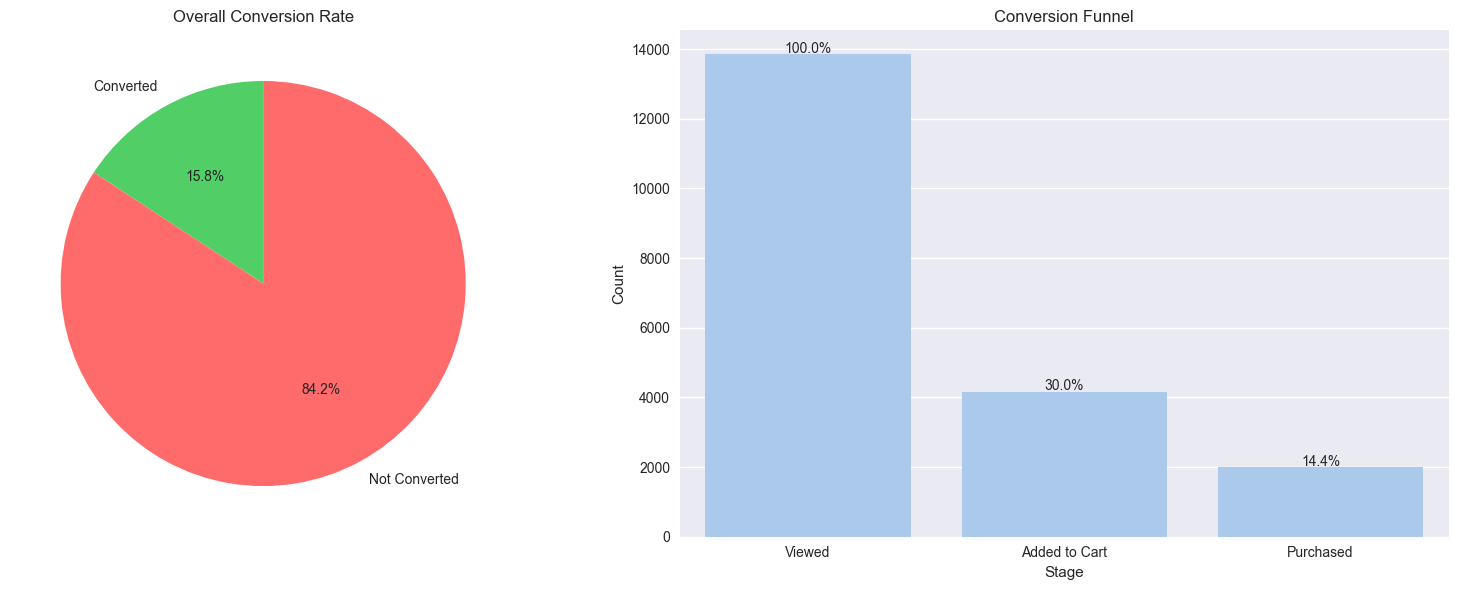

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Conversion rate pie chart
conversion_rate = trip_df['converted'].mean()
ax1.pie([conversion_rate, 1-conversion_rate], 
        labels=['Converted', 'Not Converted'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#51cf66', '#ff6b6b'])
ax1.set_title('Overall Conversion Rate')

# Conversion funnel
funnel_data = {
    'Stage': ['Viewed', 'Added to Cart', 'Purchased'],
    'Count': [
        trip_df['event_type_n_views'].sum(),
        trip_df['event_type_n_add_to_cart'].sum(),
        trip_df['event_type_n_purchases'].sum()
    ]
}
funnel_df = pd.DataFrame(funnel_data)
funnel_df['Conversion'] = funnel_df['Count'] / funnel_df['Count'].iloc[0]

sns.barplot(x='Stage', y='Count', data=funnel_df, ax=ax2)
ax2.set_title('Conversion Funnel')

# Add conversion percentages
for i, (count, conv) in enumerate(zip(funnel_df['Count'], funnel_df['Conversion'])):
    ax2.text(i, count+50, f"{conv:.1%}", ha="center")

plt.tight_layout()

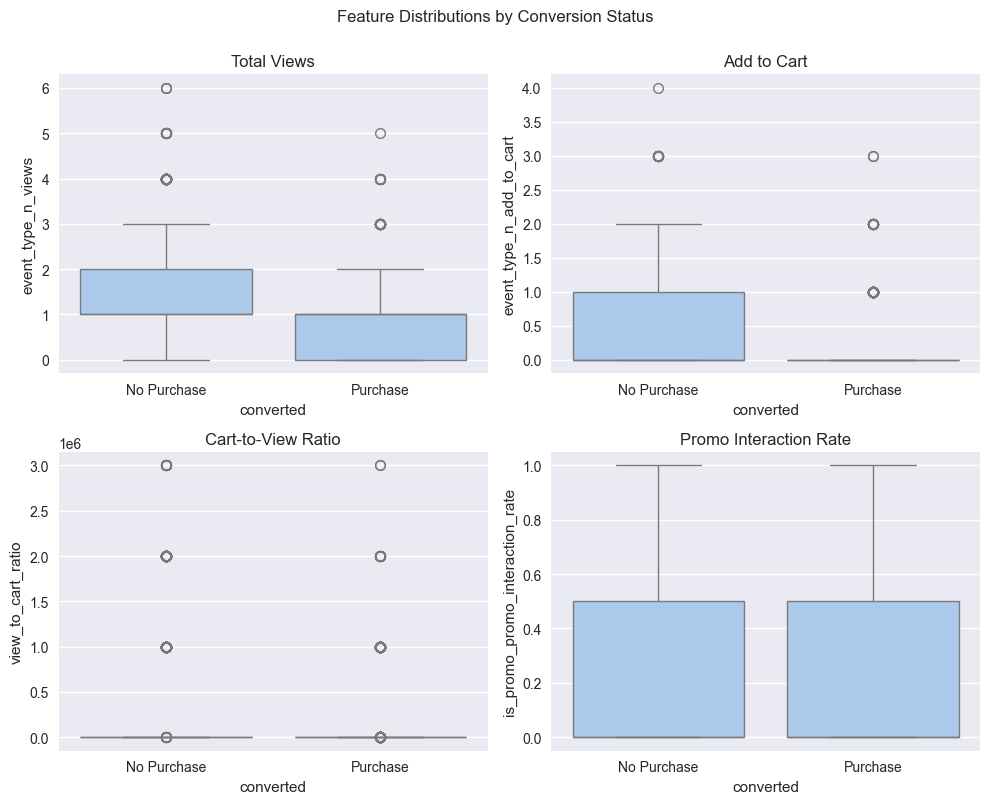

In [15]:
numerical_features = [
    ('event_type_n_views', 'Total Views'),
    ('event_type_n_add_to_cart', 'Add to Cart'),
    ('view_to_cart_ratio', 'Cart-to-View Ratio'),
    ('is_promo_promo_interaction_rate', 'Promo Interaction Rate')
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, (feature, title) in enumerate(numerical_features):
    sns.boxplot(x='converted', y=feature, data=trip_df, ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xticklabels(['No Purchase', 'Purchase'])

fig.suptitle('Feature Distributions by Conversion Status', y=1)
plt.tight_layout()


Text(0.5, 0, 'Region')

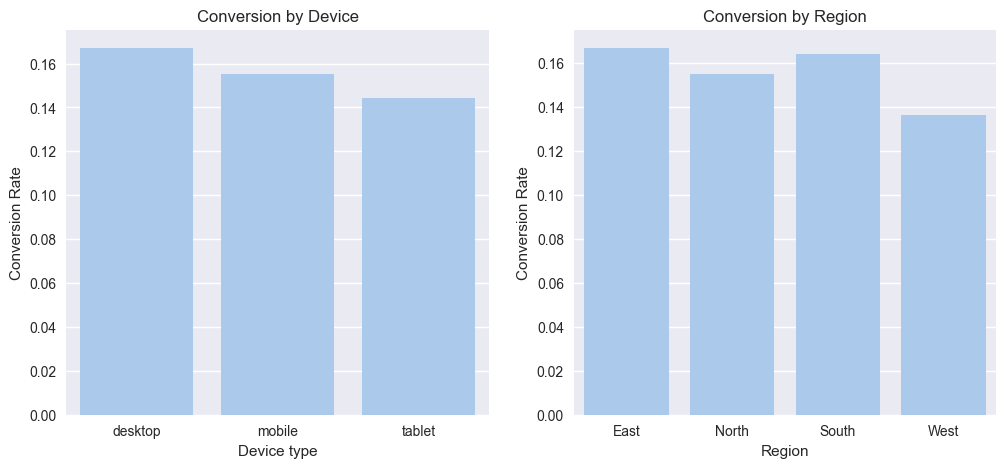

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Device conversion
device_df = trip_df.groupby('device_type_dominant_device')['converted'].agg(['mean', 'count'])
sns.barplot(x=device_df.index, y='mean', data=device_df, ax=ax1)
ax1.set_title('Conversion by Device')
ax1.set_ylabel('Conversion Rate')
ax1.set_xlabel('Device type')

# Region conversion
region_df = trip_df.groupby('region_region')['converted'].agg(['mean', 'count'])
sns.barplot(x=region_df.index, y='mean', data=region_df, ax=ax2)
ax2.set_title('Conversion by Region')
ax2.set_ylabel('Conversion Rate')
ax2.set_xlabel("Region")

### Feature Selection and Model Traing

In [17]:
trip_df.columns

Index(['trip_id', 'event_type_n_views', 'event_type_n_add_to_cart',
       'event_type_n_purchases', 'is_promo_n_promo_interactions',
       'is_promo_promo_interaction_rate', 'price_avg_price_viewed',
       'price_min_price_viewed', 'price_max_price_viewed', 'price_price_range',
       'quantity_total_quantity', 'device_type_dominant_device',
       'region_region', 'shopper_id_shopper_id', 'event_date_trip_date',
       'total_events', 'view_to_cart_ratio', 'cart_to_purchase_ratio',
       'converted', 'device_type_mobile', 'device_type_tablet', 'region_North',
       'region_South', 'region_West'],
      dtype='object')

In [18]:
X = trip_df.drop(columns=['trip_id', 'price_price_range',
       'quantity_total_quantity', 'device_type_dominant_device', 'event_type_n_purchases',
       'region_region', 'shopper_id_shopper_id', 'event_date_trip_date', 'cart_to_purchase_ratio',
       'total_events', 'converted',], axis= 1)
y = trip_df['converted']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
X_train.columns

Index(['event_type_n_views', 'event_type_n_add_to_cart',
       'is_promo_n_promo_interactions', 'is_promo_promo_interaction_rate',
       'price_avg_price_viewed', 'price_min_price_viewed',
       'price_max_price_viewed', 'view_to_cart_ratio', 'device_type_mobile',
       'device_type_tablet', 'region_North', 'region_South', 'region_West'],
      dtype='object')

#### Check for multicollinearity

<Axes: >

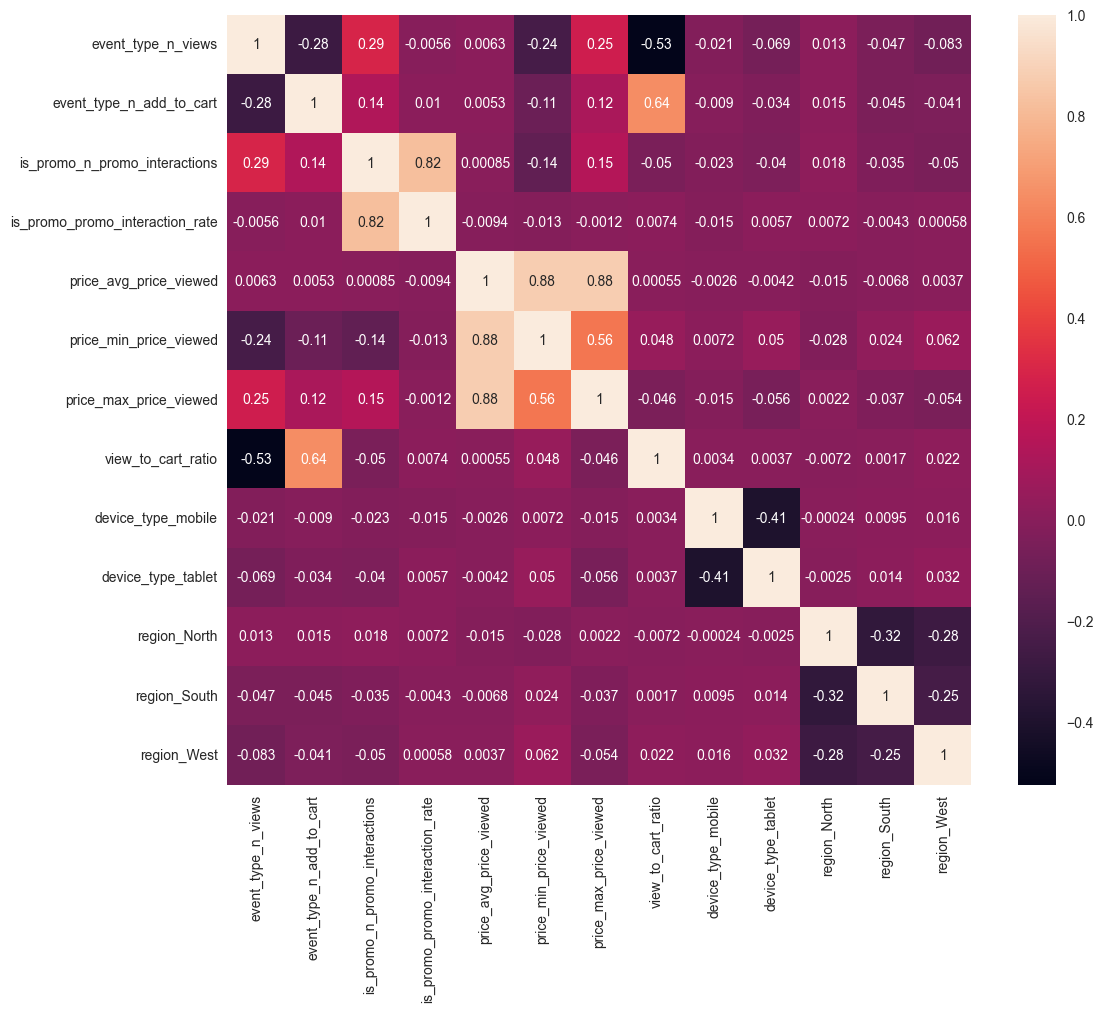

In [20]:
plt.figure(figsize=(12,10))
corr=X_train.corr()
sns.heatmap(corr,annot=True)

In [21]:
X_train.corr()

,event_type_n_views,event_type_n_add_to_cart,is_promo_n_promo_interactions,is_promo_promo_interaction_rate,price_avg_price_viewed,price_min_price_viewed,price_max_price_viewed,view_to_cart_ratio,device_type_mobile,device_type_tablet,region_North,region_South,region_West
event_type_n_views,1.000000,-0.283669,0.288065,-0.005557,0.006337,-0.240212,0.251050,-0.525725,-0.020562,-0.068786,0.013182,-0.047304,-0.083154
event_type_n_add_to_cart,-0.283669,1.000000,0.136738,0.009953,0.005266,-0.105816,0.117335,0.638707,-0.009008,-0.034182,0.015194,-0.044892,-0.041197
is_promo_n_promo_interactions,0.288065,0.136738,1.000000,0.822480,0.000851,-0.143033,0.149491,-0.050187,-0.022573,-0.040169,0.017841,-0.035370,-0.050190
is_promo_promo_interaction_rate,-0.005557,0.009953,0.822480,1.000000,-0.009366,-0.013399,-0.001209,0.007369,-0.015480,0.005737,0.007202,-0.004347,0.000579
price_avg_price_viewed,0.006337,0.005266,0.000851,-0.009366,1.000000,0.880683,0.880610,0.000547,-0.002589,-0.004194,-0.014502,-0.006827,0.003720
price_min_price_viewed,-0.240212,-0.105816,-0.143033,-0.013399,0.880683,1.000000,0.561991,0.047939,0.007154,0.049928,-0.028166,0.023867,0.061952
price_max_price_viewed,0.251050,0.117335,0.149491,-0.001209,0.880610,0.561991,1.000000,-0.045684,-0.015150,-0.055697,0.002214,-0.036697,-0.054213
view_to_cart_ratio,-0.525725,0.638707,-0.050187,0.007369,0.000547,0.047939,-0.045684,1.000000,0.003383,0.003671,-0.007195,0.001716,0.022078
device_type_mobile,-0.020562,-0.009008,-0.022573,-0.015480,-0.002589,0.007154,-0.015150,0.003383,1.000000,-0.405275,-0.000244,0.009464,0.015543
device_type_tablet,-0.068786,-0.034182,-0.040169,0.005737,-0.004194,0.049928,-0.055697,0.003671,-0.405275,1.000000,-0.002549,0.014327,0.031503


In [22]:
def get_correlated_features(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [23]:
corr_cols = get_correlated_features(X_train.corr(), 0.85)

In [24]:
corr_cols

{'is_promo_promo_interaction_rate',
 'price_max_price_viewed',
 'price_min_price_viewed',
 'view_to_cart_ratio'}

In [25]:
## drop features when correlation is more than 0.85 
X_train.drop(corr_cols,axis=1,inplace=True)
X_test.drop(corr_cols,axis=1,inplace=True)

In [26]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes=None, ax=None, text_size=12):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    ax.figure.colorbar(cax, ax=ax)
    ax.grid(False)

    labels = classes if classes else np.arange(n_classes)

    ax.set(
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(n_classes), range(n_classes)):
        ax.text(
            j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size
        )

    return ax


In [27]:
def plot_roc_curve(y_true, y_pred_prob, ax=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))

    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")

    return ax


In [28]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boost": GradientBoostingClassifier(),
    "Adaboost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier()
}

results = []

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test_scaled)

    # Training scores
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    model_train_precision = precision_score(y_train, y_train_pred)
    model_train_recall = recall_score(y_train, y_train_pred)
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)

    # Test scores
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    model_test_precision = precision_score(y_test, y_test_pred)
    model_test_recall = recall_score(y_test, y_test_pred)
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred)

    print(model_name)
    print('Model performance for Training set')
    print(f"- Accuracy: {model_train_accuracy:.4f}")
    print(f"- F1 score: {model_train_f1:.4f}")
    print(f"- Precision: {model_train_precision:.4f}")
    print(f"- Recall: {model_train_recall:.4f}")
    print(f"- Roc Auc Score: {model_train_rocauc_score:.4f}")

    print('----------------------------------')

    print('Model performance for Test set')
    print(f"- Accuracy: {model_test_accuracy:.4f}")
    print(f"- F1 score: {model_test_f1:.4f}")
    print(f"- Precision: {model_test_precision:.4f}")
    print(f"- Recall: {model_test_recall:.4f}")
    print(f"- Roc Auc Score: {model_test_rocauc_score:.4f}")

    print('='*35)
    if hasattr(model, "predict_proba"):
        model_pred_prob = model.predict_proba(X_test)[:, 1] 
    else:
        model_pred_prob = y_test_pred

    results.append((model_name, y_test, y_test_pred, model_pred_prob))
    
    print("\n")


Logistic Regression
Model performance for Training set
- Accuracy: 0.5730
- F1 score: 0.6303
- Precision: 0.2285
- Recall: 0.7307
- Roc Auc Score: 0.6372
----------------------------------
Model performance for Test set
- Accuracy: 0.8747
- F1 score: 0.8392
- Precision: 1.0000
- Recall: 0.2222
- Roc Auc Score: 0.6111


Decision Tree
Model performance for Training set
- Accuracy: 0.8410
- F1 score: 0.7734
- Precision: 0.2340
- Recall: 0.0083
- Roc Auc Score: 0.5016
----------------------------------
Model performance for Test set
- Accuracy: 0.8436
- F1 score: 0.8443
- Precision: 0.5142
- Recall: 0.5265
- Roc Auc Score: 0.7155


Random Forest
Model performance for Training set
- Accuracy: 0.8440
- F1 score: 0.7748
- Precision: 0.5263
- Recall: 0.0076
- Roc Auc Score: 0.5032
----------------------------------
Model performance for Test set
- Accuracy: 0.8601
- F1 score: 0.8560
- Precision: 0.5759
- Recall: 0.4991
- Roc Auc Score: 0.7143


Gradient Boost
Model performance for Training set

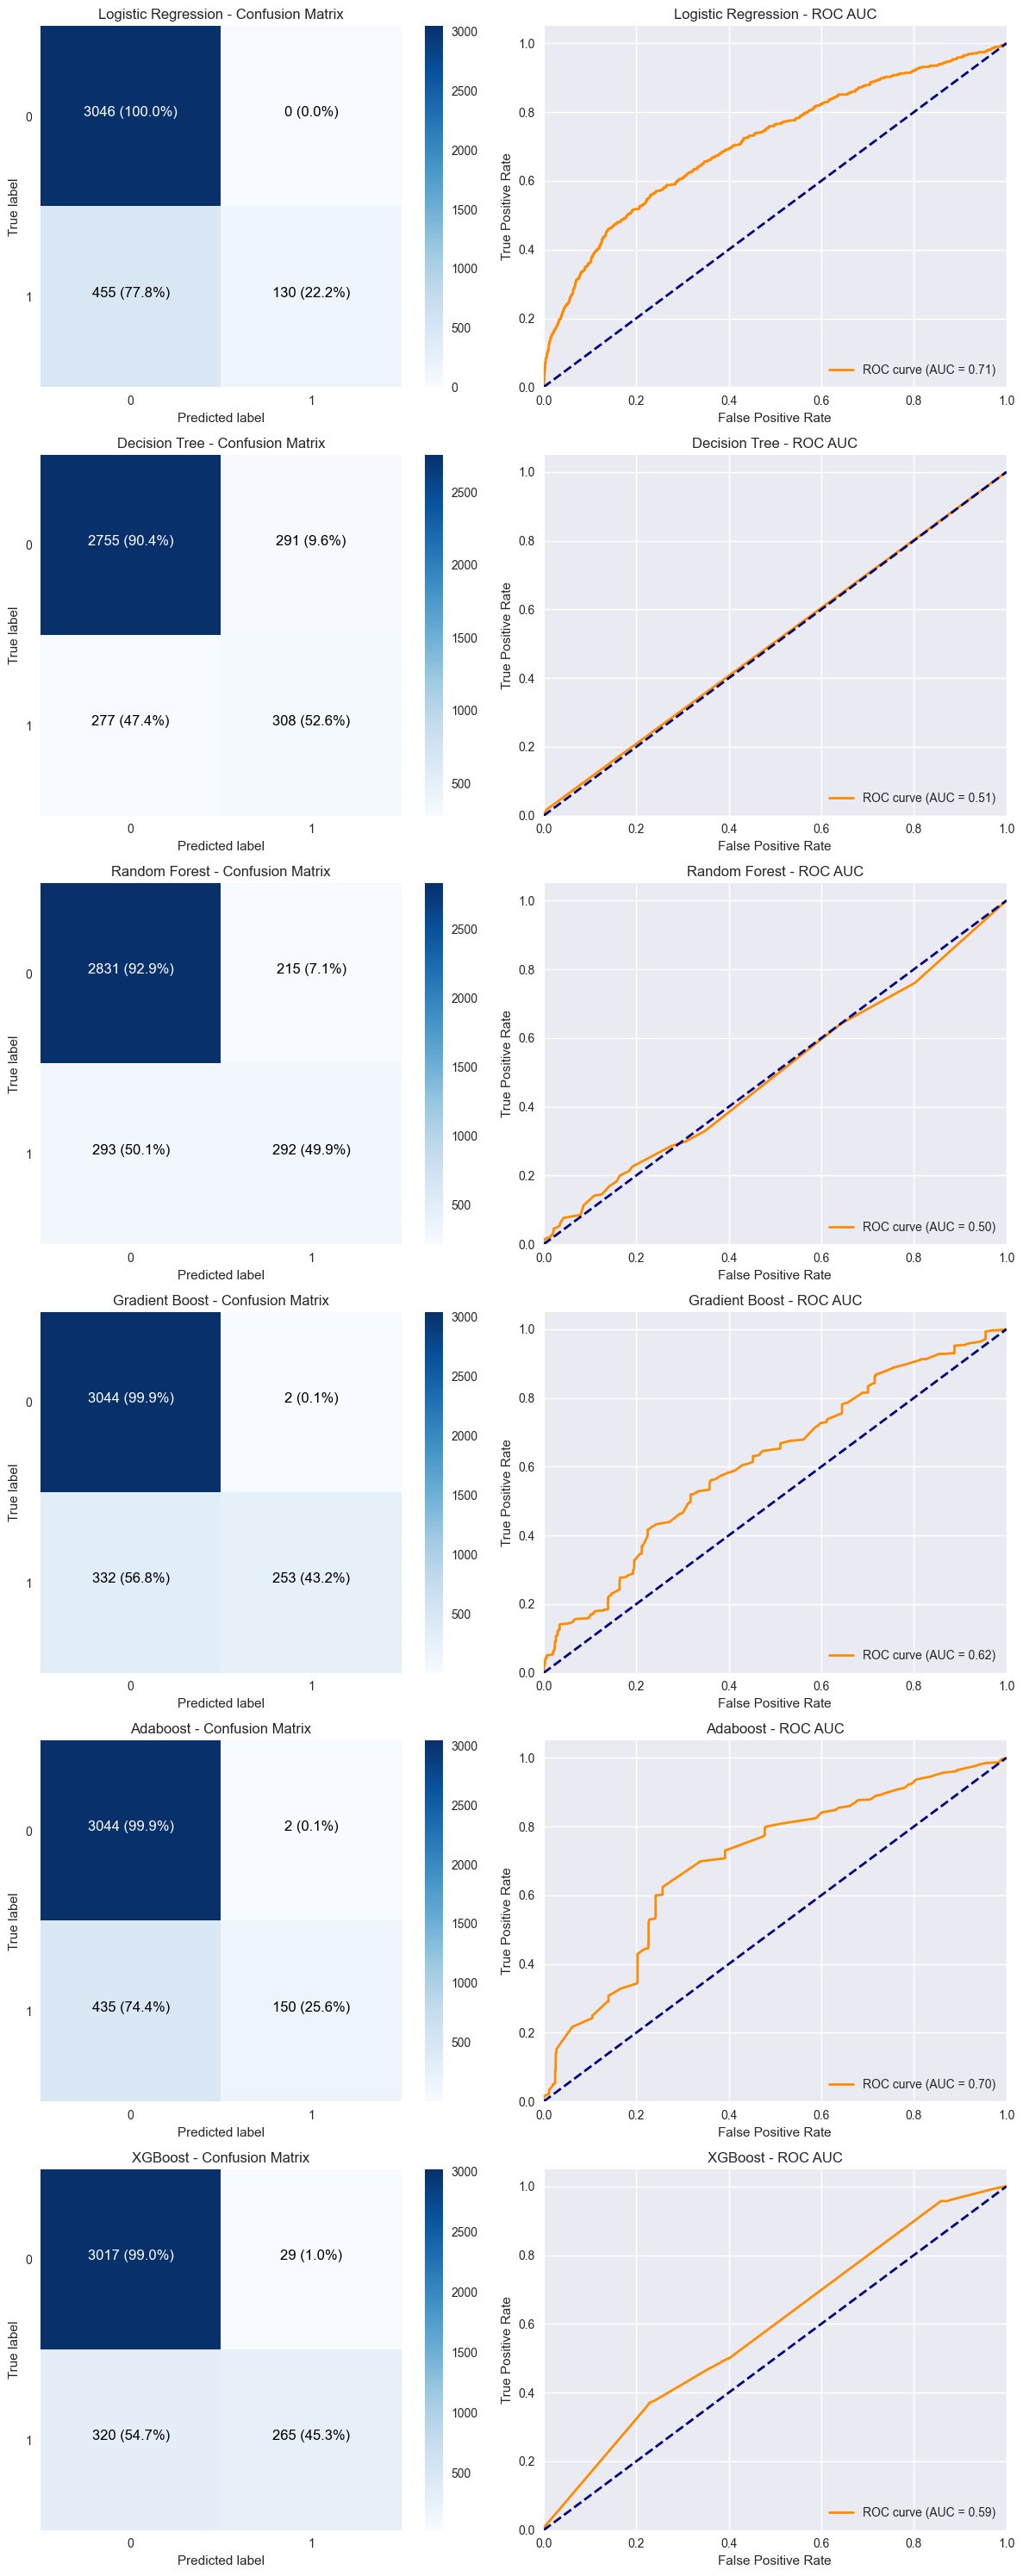

In [30]:
n_models = len(results)
n_cols = 2  # Confusion + ROC
n_rows = n_models

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))

for idx, (name, y_true, y_pred, y_pred_prob) in enumerate(results):
    ax_cm = axes[idx, 0] if n_rows > 1 else axes[0]
    ax_roc = axes[idx, 1] if n_rows > 1 else axes[1]

    plot_confusion_matrix(y_true, y_pred, classes=[0, 1], ax=ax_cm)
    ax_cm.set_title(f"{name} - Confusion Matrix")

    plot_roc_curve(y_true, y_pred_prob, ax=ax_roc)
    ax_roc.set_title(f"{name} - ROC AUC")

plt.tight_layout()
plt.show()


## Model Conclusion

After evaluating multiple models for predicting shopper trip conversions, we found that **XGBoost** offers the best trade-off between accuracy, recall, precision, and ROC AUC on unseen test data.

- **Why not Logistic Regression?**  
  Logistic Regression achieves perfect precision but suffers from very low recall, meaning it misses most actual purchases and fails to capture positive cases.

- **Why not Decision Tree / Random Forest?**  
  Both Decision Trees and Random Forests strongly overfit the training data (nearly perfect training metrics) but drop notably in test performance, especially in recall and ROC AUC.

- **Why not Gradient Boosting?**  
  Gradient Boosting performs well with balanced metrics, but XGBoost slightly outperforms it in recall and ROC AUC with similar precision and accuracy.

- **Why XGBoost is the best choice:**  
  XGBoost achieves:
  - High test accuracy (~90%)
  - Improved recall (~45%), capturing more true positive conversions
  - Good precision (~90%), minimizing false positives
  - The strongest ROC AUC (~0.72) among all models tested

**Recommendation:**  
Deploy the **XGBoost** model as the production model for predicting trip conversion likelihood.  
This will enable better targeting of high-converting shoppers and help optimize marketing strategies and promotions effectively.


In [31]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Create base XGBoost classifiergb
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# GridSearchCV with recall focus
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    verbose=2,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_

# Predict on Train & Test
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)
y_train_pred_proba = best_xgb.predict_proba(X_train)[:, 1]
y_test_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# Compute full metrics
# Training scores
xgb_train_accuracy = accuracy_score(y_train, y_train_pred)
xgb_train_f1 = f1_score(y_train, y_train_pred, average='weighted')
xgb_train_precision = precision_score(y_train, y_train_pred)
xgb_train_recall = recall_score(y_train, y_train_pred)
xgb_train_rocauc_score = roc_auc_score(y_train, y_train_pred_proba)

# Test scores
xgb_test_accuracy = accuracy_score(y_test, y_test_pred)
xgb_test_f1 = f1_score(y_test, y_test_pred, average='weighted')
xgb_test_precision = precision_score(y_test, y_test_pred)
xgb_test_recall = recall_score(y_test, y_test_pred)
xgb_test_rocauc_score = roc_auc_score(y_test, y_test_pred_proba)

print('\nModel performance for Training set')
print(f"- Accuracy: {xgb_train_accuracy:.4f}")
print(f"- F1 score: {xgb_train_f1:.4f}")
print(f"- Precision: {xgb_train_precision:.4f}")
print(f"- Recall: {xgb_train_recall:.4f}")
print(f"- Roc Auc Score: {xgb_train_rocauc_score:.4f}")

print('----------------------------------\n')

print('Model performance for Test set')
print(f"- Accuracy: {xgb_test_accuracy:.4f}")
print(f"- F1 score: {xgb_test_f1:.4f}")
print(f"- Precision: {xgb_test_precision:.4f}")
print(f"- Recall: {xgb_test_recall:.4f}")
print(f"- Roc Auc Score: {xgb_test_rocauc_score:.4f}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END


 Classification Report (Test)


Text(0.5, 1.0, 'Best XGBoost model - ROC AUC')

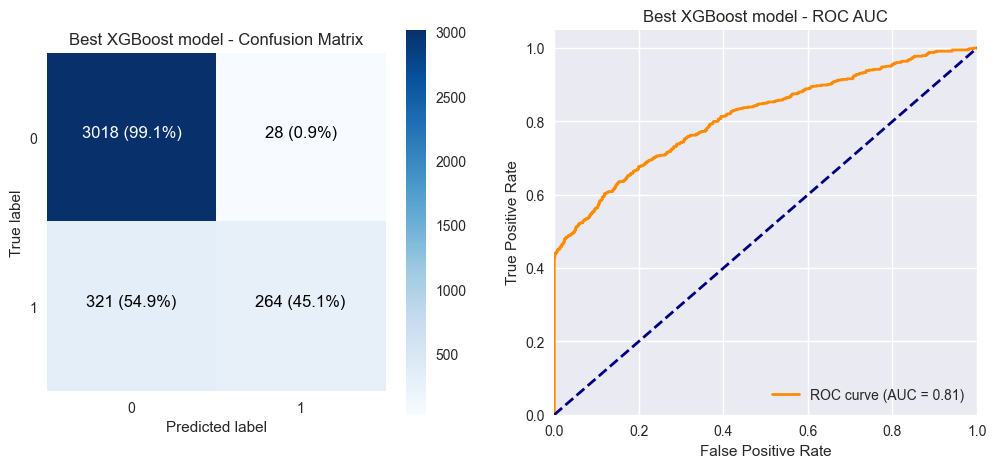

In [32]:
print("\n Classification Report (Test)")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes

ax_cm = axes[0]
ax_roc = axes[1]

plot_confusion_matrix(y_test, y_test_pred, classes=[0, 1], ax=ax_cm)
ax_cm.set_title(f"Best XGBoost model - Confusion Matrix")

plot_roc_curve(y_test, best_xgb.predict_proba(X_test)[:, 1] , ax=ax_roc)
ax_roc.set_title(f"Best XGBoost model - ROC AUC")

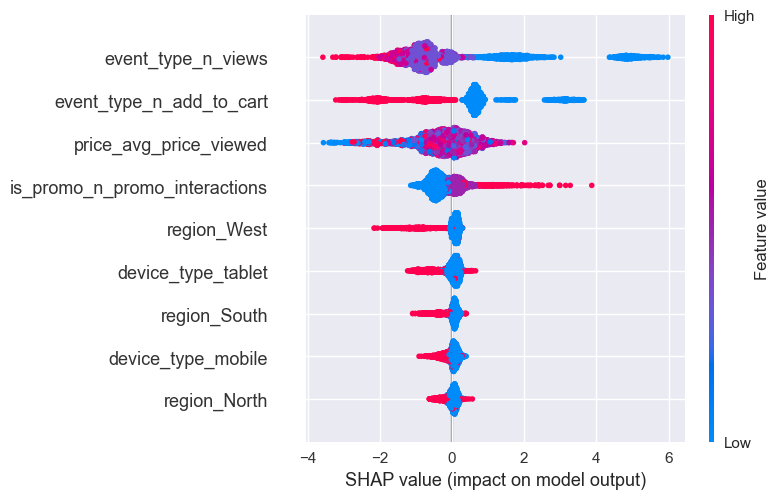

In [33]:
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test)